In [ ]:
!unzip "Data_resized.zip"

# **Data Preprocessing**

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def extension_to_txt(filename):
  return os.path.splitext(filename)[0] + '.txt'

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def myimshow(img):
    plt.imshow(img, cmap="gray")
    plt.show()

def standardize(A):
  return (A - np.mean(A)) / (np.max(A) - np.mean(A))

In [4]:
classes = dict()
with open("classes_MASTER.txt", 'r') as f:
  index = 0
  for line in f:
    classes[index] = line[:-1]
    index += 1
print("classes:")
print(classes)
labels_df = pd.read_csv("labels.csv")
labels_dict = labels_df.set_index('image_name')["class"].to_dict()
print("labels length:")
print(len(labels_dict))
print("labels:")
print(labels_dict)

classes:
{0: 'bottle', 1: 'utensils', 2: 'chip_bag', 3: 'soda_can', 4: 'napkin', 5: 'condiment_packets', 6: 'bowl', 7: 'chopsticks', 8: 'subway_bag', 9: 'starbucks_glass_bottle', 10: 'drinking_straw', 11: 'clamshell_containers', 12: 'beverage_cup', 13: 'clear_plastic_container', 14: 'coffee_cu'}
labels length:
3141
labels:
{'00a36f96e31731c4.txt': 0, '00b729b5187a1898.txt': 0, '012b0f6b12da485f.txt': 1, '01495549e1f4fd2e.txt': 0, '024fc048dd1cb61a.txt': 0, '026fa3777c04b863.txt': 1, '02d301de1b793797.txt': 1, '02eaecd683dbdb9f.txt': 1, '02eec2c28f8cdb8e.txt': 1, '0344cade36bbd4f4.txt': 1, '03e3825b1b538688.txt': 1, '049ea73ac853d016.txt': 1, '04bcc24c07f719a5.txt': 7, '052ed3190494c65d.txt': 7, '0713109a36fd0303.txt': 7, '07de9510e802a400.txt': 1, '085622859f9b4eb2.txt': 1, '09a9a9d1fe0a592a.txt': 1, '09f795d4ef82046f.txt': 7, '0a0c94f67dd7ab3c.txt': 7, '0a891eacc7232d25.txt': 1, '0aa532f51ab031fe.txt': 1, '0acfa779589204bf.txt': 0, '0aec86633421382f.txt': 1, '0b5b9dc7c5f88bff.txt': 1,

In [5]:
import os

X_list = []
Y_list = []
image_names = []
invalid_size = 0
unlabeled_images = []

for file in os.listdir("Data_resized"):
  numpy_file = plt.imread("Data_resized/" + file);
  if np.shape(numpy_file) == (117,128):
    if extension_to_txt(file) in labels_dict:
      X_list.append(numpy_file)
      Y_list.append(labels_dict[extension_to_txt(file)])
      image_names.append(file)
  else:
    invalid_size += 1

if invalid_size > 0:
  print("Some images are not correctly resized")

In [6]:
data_set = []
for i in range(len(X_list)):
  data_set.append((torch.from_numpy(standardize(X_list[i])).reshape(1,117,128), Y_list[i]))
np.random.shuffle(data_set)
split_point_val = int(len(X_list) * 0.6)
split_point_test = int(len(X_list) * 0.8)
train_set = data_set[:split_point_val]
val_set = data_set[split_point_val:split_point_test]
test_set = data_set[split_point_test:]
print("train_set: ", str(len(train_set)))
print("val_set: ", str(len(val_set)))
print("test_set: ", str(len(test_set)))
print("total:" , str(len(train_set) + len(val_set) + len(test_set)))

train_set:  1862
val_set:  621
test_set:  621
total: 3104


In [7]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


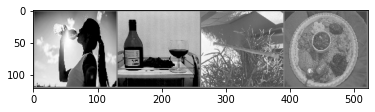

['bottle', 'bottle', 'utensils', 'utensils']


In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print([classes[int(labels[i])] for i in range(4)])

# **Simple Neural Network**
**Convolutional layers:**1-50-80

**output layers:**64800-1200-840-14

**Dropout:** 0.4

**l2 decay:** 0.06

**batch_size:** 10

**epoches:** 200

_______________________

**Result:**

**training accuracy:** 99.41%

**validation accuracy:** 55.56%

**test accuracy:** 55.07%





In [37]:
#load the model
#trained model was failed to be downloaded from googlecolab as it is really big (~300M)
simpleModel = SimpleModel()
simpleModel.load_state_dict(torch.load("model.txt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
simpleModel.to(device)
simpleModel.eval()

cuda:0


SimpleModel(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(50, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64800, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=840, bias=True)
  (fc3): Linear(in_features=840, out_features=14, bias=True)
)

In [18]:
 import torch.optim as optim

dropout = 0.4

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(50)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(30, 80, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(80)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(80 * 27 * 30, 1200)
        self.fc2 = nn.Linear(1200, 840)
        self.fc3 = nn.Linear(840, 14)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = x.view(-1, 80 * 27 * 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

simpleModel = SimpleModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
simpleModel.to(device)

cuda:0


SimpleModel(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(50, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64800, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=840, bias=True)
  (fc3): Linear(in_features=840, out_features=14, bias=True)
)

In [19]:
lr = 0.08
weight_decay = 0.06
step_size = 20
gamma = 0.6
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simpleModel.parameters(), lr = lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


In [25]:
tr_accuacy2 = []
tr_loss2 = []
va_accuacy2 = []
va_loss2 = []

batch_size_i = 10
for epoch in range(300):  # loop over the dataset multiple times
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_i, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_i, shuffle=False, num_workers=2)
    train_total = 0
    train_correct = 0
    va_total = 0
    va_correct = 0
    training_loss = 0.0
    vaild_loss = 0.0
    training_data_size = 0
    va_data_size = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), \
          labels.to(device)
        optimizer.zero_grad()
        outputs = simpleModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        optimizer.step()
        training_loss += loss.item()
        training_data_size = i
    tr_accuacy2.append(train_correct / train_total)
    tr_loss2.append(training_loss / (training_data_size + 1))

    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), \
          labels.to(device)
        optimizer.zero_grad()
        outputs = simpleModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        va_total += labels.size(0)
        va_correct += (predicted == labels).sum().item()
        vaild_loss += loss.item()
        va_data_size = i
    va_accuacy2.append(va_correct / va_total)
    va_loss2.append(vaild_loss / (va_data_size + 1))
    if scheduler.get_lr()[0] > 0.0003:
        scheduler.step()
    if epoch % 10 == 0:

        print('epoch %d learning rate:%.5f| training loss:%.3f, training accuracy:%.2f%%, validation loss:%.3f, validation accuracy:%.2f%%' 
              %(epoch + 1, scheduler.get_last_lr()[0], training_loss / (training_data_size + 1), \
                100 * train_correct / train_total, \
                vaild_loss / (va_data_size + 1), 100 * va_correct / va_total))

epoch 1 learning rate:0.00048| training loss:0.163, training accuracy:99.14%, validation loss:1.407, validation accuracy:54.59%


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


epoch 11 learning rate:0.00048| training loss:0.161, training accuracy:99.30%, validation loss:1.409, validation accuracy:55.72%
epoch 21 learning rate:0.00048| training loss:0.167, training accuracy:99.09%, validation loss:1.420, validation accuracy:55.88%
epoch 31 learning rate:0.00048| training loss:0.164, training accuracy:98.93%, validation loss:1.410, validation accuracy:56.52%
epoch 41 learning rate:0.00048| training loss:0.163, training accuracy:99.09%, validation loss:1.387, validation accuracy:54.43%
epoch 51 learning rate:0.00048| training loss:0.164, training accuracy:99.09%, validation loss:1.403, validation accuracy:55.23%
epoch 61 learning rate:0.00048| training loss:0.163, training accuracy:99.30%, validation loss:1.441, validation accuracy:55.72%
epoch 71 learning rate:0.00048| training loss:0.164, training accuracy:99.19%, validation loss:1.367, validation accuracy:56.04%
epoch 81 learning rate:0.00048| training loss:0.163, training accuracy:99.14%, validation loss:1.

KeyboardInterrupt: ignored

In [39]:
test_total = 0
test_correct = 0
test_loss = 0.0
test_data_size = 0
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device, dtype=torch.float), \
      labels.to(device)
    optimizer.zero_grad()
    outputs = simpleModel(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()
    test_loss += loss.item()
    test_data_size = i
print("test loss:%.3f, test accuracy:%.2f%%" %(\
      test_loss / (test_data_size + 1), 100 * test_correct / test_total))

test loss:1.405, test accuracy:55.23%


In [31]:
torch.save(simpleModel.state_dict(), "model.txt")